In [9]:
import pandas as pd

df = pd.read_csv("netflix_reviews.csv")  # 파일 불러오기
print("Shape of the dataset:", df.shape)
print("Columns in the dataset:", df.columns)

Shape of the dataset: (117134, 8)
Columns in the dataset: Index(['reviewId', 'userName', 'content', 'score', 'thumbsUpCount',
       'reviewCreatedVersion', 'at', 'appVersion'],
      dtype='object')


In [10]:
def preprocess_text(text):
    if isinstance(text, float):
        return ""
    text = text.lower()  # 대문자를 소문자로
    text = re.sub(r'[^\w\s]', '', text)  # 구두점 제거
    text = re.sub(r'\d+', '', text)  # 숫자 제거
    text = text.strip()  # 띄어쓰기 제외하고 빈 칸 제거
    return text

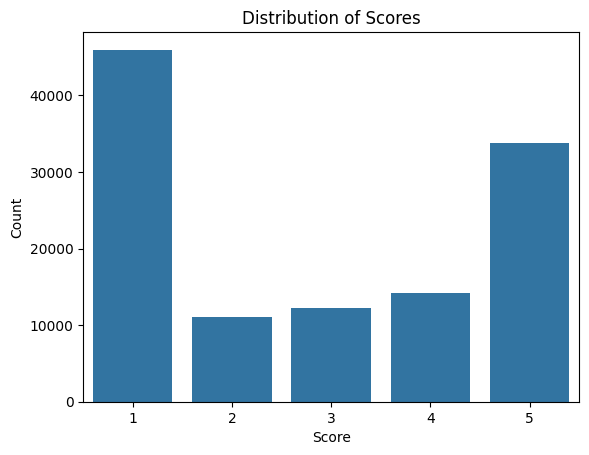

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# 스코어 별 리뷰 개수 계산
score_counts = df['score'].value_counts().reset_index()
score_counts.columns = ['Score', 'Count']  # 열 이름 변경

# 그래프 그리기
sns.barplot(x='Score', y='Count', data=score_counts)
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of Scores')
plt.show()

In [12]:

import re
import torch 
import torch.nn as nn
import torch.optim as optim
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 리뷰와 점수 추출
df['content'] = df['content'].apply(preprocess_text)  # 텍스트 전처리
reviews = df['content'].tolist()  # 리뷰 리스트
ratings = df['score'].tolist()  # 점수 리스트

# 텍스트 파이프라인 정의
tokenizer = get_tokenizer("basic_english")
vocab = build_vocab_from_iterator(map(tokenizer, reviews), specials=["<unk>"])
label_encoder = LabelEncoder()
encoded_ratings = label_encoder.fit_transform(ratings)

# 텍스트 파이프라인 함수 정의
def text_pipeline(text):
    return [vocab[token] if token in vocab else vocab["<unk>"] for token in tokenizer(text)]

# 훈련/테스트 데이터 분할
train_reviews, test_reviews, train_ratings, test_ratings = train_test_split(
    reviews, encoded_ratings, test_size=0.2, random_state=42
)

# 데이터셋 클래스 정의
class ReviewDataset(Dataset):
    def __init__(self, reviews, ratings, text_pipeline, label_pipeline):
        self.reviews = reviews
        self.ratings = ratings
        self.text_pipeline = text_pipeline
        self.label_pipeline = label_pipeline

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.text_pipeline(self.reviews[idx])
        rating = self.label_pipeline(self.ratings[idx])
        return torch.tensor(review), torch.tensor(rating)

# 데이터셋 정의
train_dataset = ReviewDataset(train_reviews, train_ratings, text_pipeline, label_encoder.transform)
test_dataset = ReviewDataset(test_reviews, test_ratings, text_pipeline, label_encoder.transform)

# 데이터 로더 정의
BATCH_SIZE = 64
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)  # [batch_size, seq_length, embed_dim]
        output, (hidden, cell) = self.lstm(embedded)  # [batch_size, seq_length, hidden_dim]
        return self.fc(hidden[-1])  # [batch_size, output_dim]

# 하이퍼파라미터 정의
VOCAB_SIZE = len(vocab)
EMBED_DIM = 64
HIDDEN_DIM = 128
OUTPUT_DIM = len(set(ratings))  # 예측할 점수 개수

# 모델 초기화
model = LSTMModel(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM)

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 모델 학습은 직접 작성해보세요!!!

# 예측 함수(예시)
def predict_review(model, review):
    model.eval()
    with torch.no_grad():
        tensor_review = torch.tensor(text_pipeline(review)).unsqueeze(0)  # Add batch dimension
        output = model(tensor_review)
        prediction = output.argmax(1).item()
        return label_encoder.inverse_transform([prediction])[0]

# 새로운 리뷰에 대한 예측
new_review = "This app is great but has some bugs."
predicted_score = predict_review(model, new_review)
print(f'Predicted Score: {predicted_score}')


Predicted Score: 5
